In [1]:

import numpy as np
import jax
import jax.numpy as jnp

from scoobpsf.imshows import *
import scoobpsf.jax_scoob as jscoob
import scoobpsf.jax_dm as jdm

from scoobpsf.jax_scoob import ensure_np_array

from jax.scipy.optimize import minimize

from importlib import reload



Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


In [3]:
reload(jscoob)
model = jscoob.SCOOB(npix=128, oversample=16, npsf=200)

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


2023-09-19 17:10:28.603612: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


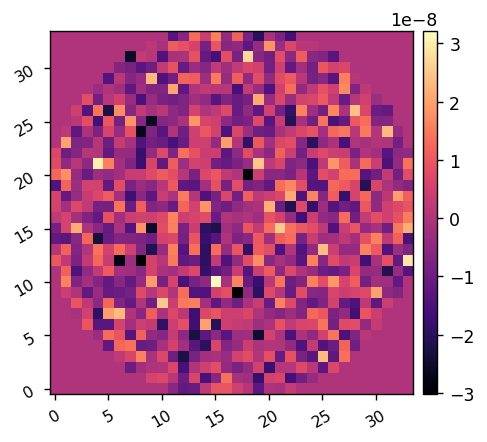

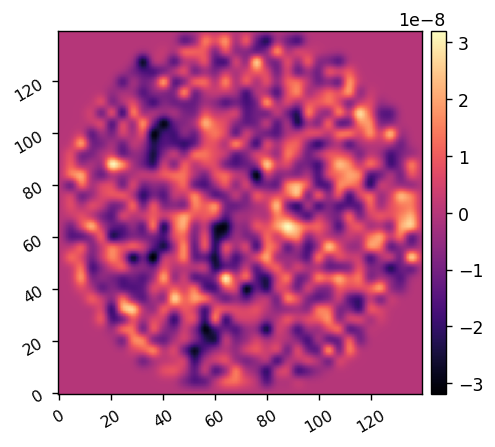

In [4]:
model.set_dm(np.random.randn(model.Nacts)*1e-8)
imshow1(model.get_dm())
imshow1(ensure_np_array(model.get_dm_surface()))

Jax platform: gpu
Jax device: NVIDIA A100 80GB PCIe


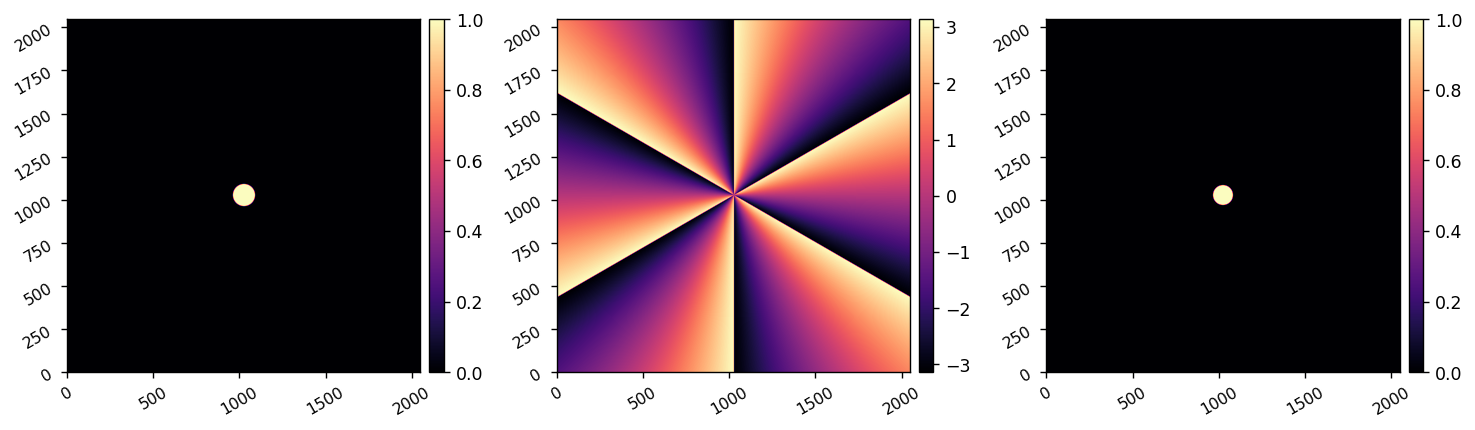

In [9]:
reload(jscoob)
VC = jscoob.make_vortex_phase_mask(model.focal_grid_pol, singularity=20*u.um)
LS = model.pupil_grid[0] < model.pupil_diam.to_value(u.m)/2 * 0.9
imshow3(ensure_np_array(model.PUPIL), np.angle(jscoob.ensure_np_array(VC)), ensure_np_array(LS))

In [14]:
model.focal_grid_pol[0]

Array([[90.46547382, 90.42129044, 90.37712869, ..., 90.37712869,
        90.42129044, 90.46547382],
       [90.42129044, 90.37708547, 90.33290211, ..., 90.33290211,
        90.37708547, 90.42129044],
       [90.37712869, 90.33290211, 90.28869712, ..., 90.28869712,
        90.33290211, 90.37712869],
       ...,
       [90.37712869, 90.33290211, 90.28869712, ..., 90.28869712,
        90.33290211, 90.37712869],
       [90.42129044, 90.37708547, 90.33290211, ..., 90.33290211,
        90.37708547, 90.42129044],
       [90.46547382, 90.42129044, 90.37712869, ..., 90.37712869,
        90.42129044, 90.46547382]], dtype=float64)

In [18]:
sing = 20e-6
focal_length = 500e-3
D = 10e-3
lam = 650e-9

sing*D/(focal_length*lam)

0.6153846153846154

In [ ]:
singularity.to_value(u.m)*focal_length/

In [11]:
model.set_dm(np.random.randn(model.Nacts)*1e-8)
model.reset_dm()
model.FPM = VC
model.LYOT = LS
imwf = model.propagate()

In [37]:
imwf = model.propagate()

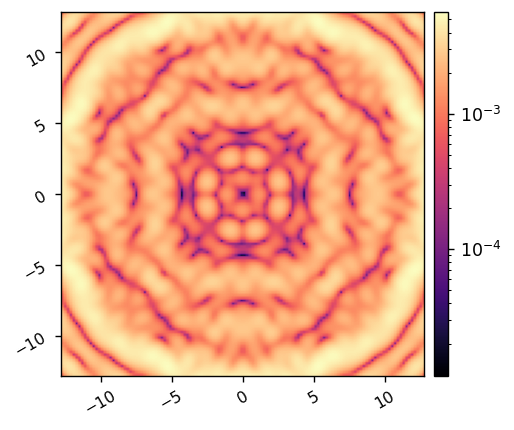

In [12]:
imshow1(jscoob.ensure_np_array(jnp.abs(imwf)), lognorm=True, pxscl=model.psf_pixelscale_lamD)